In [1]:
import json
from collections import defaultdict


mode = 1
# 1 = Nationalratswahlen

filename = "nationalrat_raw.json"
candidates = json.load(open(filename, encoding="utf-8"))

8.311712651323894


/tmp/ipykernel_134131/1214021018.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='partyAbbreviation', y='answer', data=filtered_answer_df, palette='Set2', showfliers=False)


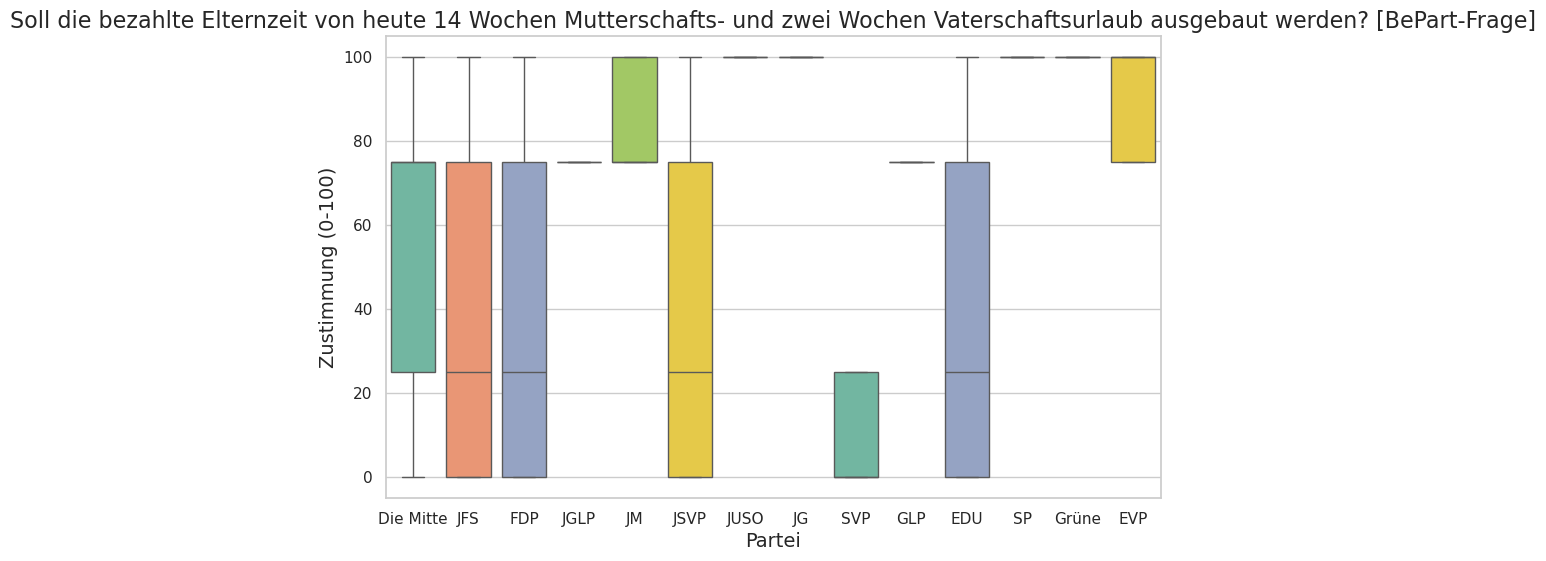

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(candidates)
answer_data = []
frage = df.head(1)['answers'][0][0]['text']
for idx, row in df.iterrows():
    for answer in row["answers"]:
       if answer["questionId"] == "32215":
        answer_data.append({
            "id": row["id"],
            "firstname": row["firstname"],
            "lastname": row["lastname"],
            "partyAbbreviation": row["partyAbbreviation"],
            "partyColor": row["partyColor"],
            "questionId": answer["questionId"],
            "answer": int(answer["value"])
            })
answer_df = pd.DataFrame(answer_data)
party_counts = answer_df['partyAbbreviation'].value_counts()
parties_to_keep = party_counts[party_counts > 100].index
filtered_answer_df = answer_df[answer_df['partyAbbreviation'].isin(parties_to_keep)]


plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create the box plot with Party Abbreviation as the x-axis and answers as the y-axis
sns.boxplot(x='partyAbbreviation', y='answer', data=filtered_answer_df, palette='Set2', showfliers=False)

# Customize the plot
plt.title(frage, fontsize=16)
plt.xlabel("Partei", fontsize=14)
plt.ylabel("Zustimmung (0-100)", fontsize=14)

plt.show()
